# Bond Option Pricing using Black-Karasinski Model

Value an option on a coupon paying bond using the Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from financepy.finutils import *
from financepy.market.curves import *
from financepy.products.libor import *
from financepy.models import *
from financepy.products.bonds import *

###################################################################
# FINANCEPY BETA Version 0.180 - This build: 10 Sep 2020 at 22:02 #
#     This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy #
###################################################################



## Bond Option Valuation

In [3]:
settlementDate = FinDate(1, 12, 2019)

Set up discount curve

In [4]:
dcType = FinDayCountTypes.ACT_360
fixedFreq = FinFrequencyTypes.SEMI_ANNUAL
swap1 = FinLiborSwap(settlementDate,"1Y",0.0500,fixedFreq,dcType)
swap2 = FinLiborSwap(settlementDate,"3Y",0.0500,fixedFreq,dcType)
swap3 = FinLiborSwap(settlementDate,"5Y",0.0500,fixedFreq,dcType)
swap4 = FinLiborSwap(settlementDate,"7Y",0.0500,fixedFreq,dcType)
swap5 = FinLiborSwap(settlementDate,"10Y",0.0500,fixedFreq,dcType)
swaps = [swap1, swap2, swap3, swap4, swap5]

liborCurve = FinLiborCurve(settlementDate, [], [], swaps)

## Set up the Bond Option

First create the bond

In [5]:
maturityDate = settlementDate.addTenor("10Y")
coupon = 0.05
frequencyType = FinFrequencyTypes.SEMI_ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)

Let's first price the bond on the libor curve

In [6]:
price = bond.cleanPriceFromDiscountCurve(settlementDate, liborCurve)
print("Fixed Income Price:", price)

Fixed Income Price: 96.95083924256632


Then define and create the option

In [7]:
expiryDate = settlementDate.addTenor("18m")
strikePrice = 90.0
face = 100.0
optionType = FinBondOptionTypes.AMERICAN_CALL

### Black Karasinski Model

Set the model parameters

In [8]:
sigma = 0.20
a = 0.05
bkModel = FinModelRatesBK(sigma, a)

In [9]:
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]

In [10]:
for K in strikes:
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, liborCurve, bkModel)
    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, liborCurve, bkModel)
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, liborCurve, bkModel)
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, liborCurve, bkModel)
    
    print("K: %9.5f EUR_CALL: %9.5f  AMER_CALL: %9.5f  EUR_PUT: %9.5f  AMER_PUT: %9.5f" %(K, v_ec, v_ac, v_ep, v_ap))

K:  80.00000 EUR_CALL:  17.62129  AMER_CALL:  18.84391  EUR_PUT:   0.01288  AMER_PUT:   0.01339
K:  85.00000 EUR_CALL:  13.30120  AMER_CALL:  15.10241  EUR_PUT:   0.06861  AMER_PUT:   0.07258
K:  90.00000 EUR_CALL:   8.76018  AMER_CALL:  10.08895  EUR_PUT:   0.27556  AMER_PUT:   0.29506
K:  95.00000 EUR_CALL:   5.10676  AMER_CALL:   5.97006  EUR_PUT:   1.00874  AMER_PUT:   1.07079
K: 100.00000 EUR_CALL:   2.16860  AMER_CALL:   3.30239  EUR_PUT:   2.57488  AMER_PUT:   3.04916
K: 105.00000 EUR_CALL:   0.59520  AMER_CALL:   0.63177  EUR_PUT:   5.67997  AMER_PUT:   8.04916
K: 110.00000 EUR_CALL:   0.09185  AMER_CALL:   0.20988  EUR_PUT:   9.57551  AMER_PUT:  13.04916
K: 115.00000 EUR_CALL:   0.00447  AMER_CALL:   0.01277  EUR_PUT:  13.85807  AMER_PUT:  18.04916
K: 120.00000 EUR_CALL:   0.00006  AMER_CALL:   0.00019  EUR_PUT:  18.61495  AMER_PUT:  23.04916


## Convergence Testing - Black-Karasinski

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [11]:
discountCurve = FinDiscountCurveFlat(settlementDate, 0.05)

In [12]:
maturityDate = FinDate(1, 9, 2025)
coupon = 0.05
frequencyType = FinFrequencyTypes.ANNUAL
accrualType = FinDayCountTypes.ACT_ACT_ICMA
bond = FinBond(maturityDate, coupon, frequencyType, accrualType)
expiryDate = settlementDate.addTenor("18m")
face = 100.0

In [13]:
numStepsVector = range(100, 1000, 5)

In [28]:
sigma = 0.00001
a = 0.05

In [29]:
K = 102.0

In [30]:
vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for numSteps in numStepsVector:
    
    bkModel = FinModelRatesBK(sigma, a, numSteps)
    
    europeanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlementDate, discountCurve, bkModel)

    americanCallBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlementDate, discountCurve, bkModel)
    
    europeanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    americanPutBondOption = FinBondOption(bond, expiryDate, K, face, FinOptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlementDate, discountCurve, bkModel)
    
    # print("%d %9.5f %9.5f %9.5f %9.5f"%(numSteps, v_ec, v_ac, v_ep, v_ap))
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

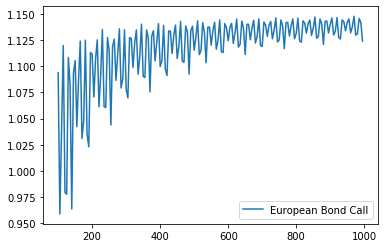

In [31]:
plt.plot(numStepsVector,vec_ec, label="European Bond Call")
plt.legend();

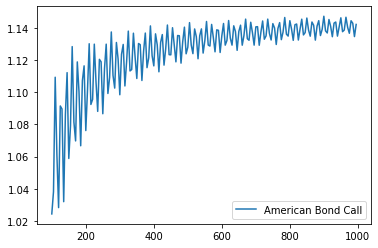

In [32]:
plt.plot(numStepsVector,vec_ac, label="American Bond Call")
plt.legend();

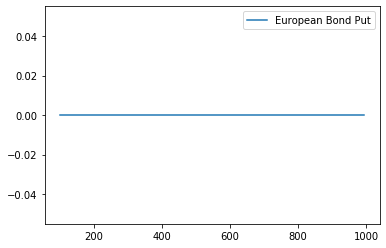

In [33]:
plt.plot(numStepsVector,vec_ep, label="European Bond Put")
plt.legend();

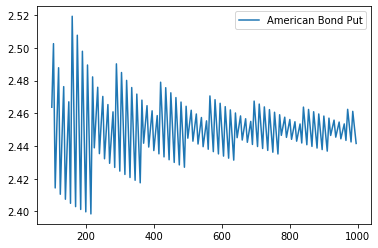

In [34]:
plt.plot(numStepsVector,vec_ap, label="American Bond Put")
plt.legend();

Copyright (c) 2020 Dominic O'Kane